<a href="https://colab.research.google.com/github/Dyakonov/Colab/blob/main/dj_DistanceLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Учим L2-расстояние

* тут не SGD - м.б. поменять
* визуализация функции ошибки

**Выучивается, если пошаманить с LR**

Проблемы, если расшарить веса по слоям.

Но тут я ещё не по батчам обучался!

Кстати, с use_scheduler = False появляется горб...

In [133]:
import torch
from torch import nn, optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [134]:
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import copy
from torch.optim.lr_scheduler import StepLR

In [135]:
# инициализация генератора псевдослучайных чисел

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # для GPU отдельный seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(43)

# есть стохастические операции на GPU
# сделаем их детерминированными для воспроизводимости
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [145]:
# при n0 = 1 это обычный модуль!!!

n0 = 5 # число признаков в одном векторе
n = 2 * n0  # общее число признаков
m = 10000 # число объектов в выборке
k = 3 # увеличение признакового пространства в сети
nlayers = 5 # число слоёв в сети
learning_rate = 1e-1
use_scheduler = True

In [146]:
def model_L_DN_F(n_input, width, nlayers):
  """
  сеть Linear + BN + ReLU
  """
  model = torch.nn.Sequential()
  model.add_module('L0', nn.Linear(n_input, width, bias=False))
  model.add_module('BN0',  nn.BatchNorm1d(width))
  for i in range(nlayers - 2):
    model.add_module('RELU' + str(i),  nn.ReLU())
    model.add_module('L'+str(i+1),  nn.Linear(width, width, bias=False)) # ДОБАВИЛ , bias=False
    model.add_module('BN'+str(i+1),  nn.BatchNorm1d(width))
  model.add_module('RELU' + str(nlayers - 2),  nn.ReLU())
  model.add_module('L' + str(nlayers - 1),  nn.Linear(width, 1))
  return(model)



# модель - ОШИБКА - есть шаринг среди слоёв
#layers = [nn.Linear(n, k*n)]
#layers += [nn.ReLU(), nn.BatchNorm1d(k*n), nn.Linear(k*n, k*n)] * (nlayers - 2)
#layers += [nn.ReLU(), nn.BatchNorm1d(k*n), nn.Linear(k*n, 1)]

# модель - нет имён слоёв
#layers = [nn.Linear(n, k*n, bias=False), nn.BatchNorm1d(k*n)]
#for i in range(nlayers - 2): # иначе будет разделение параметров
#  layers += [nn.ReLU(), nn.Linear(k*n, k*n, bias=False), nn.BatchNorm1d(k*n)]
#layers += [nn.ReLU(), nn.Linear(k*n, 1)]


# model = torch.nn.Sequential()
# model.add_module('L0', nn.Linear(n, k*n))
# model.add_module('BN0',  nn.BatchNorm1d(k*n))
# for i in range(nlayers - 2):
#   model.add_module('RELU' + str(i),  nn.ReLU())
#   model.add_module('L'+str(i+1),  nn.Linear(k*n, k*n, bias=False))
#   model.add_module('BN'+str(i+1),  nn.BatchNorm1d(k*n))
# model.add_module('RELU' + str(nlayers - 2),  nn.ReLU())
# model.add_module('L' + str(nlayers - 1),  nn.Linear(k*n, 1))




#model = nn.Linear(n, 1)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)




In [147]:
model = model_L_DN_F(n, k*n, nlayers)
model.to(device)

# MSE
criterion = nn.MSELoss()
# оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# программатор
scheduler = StepLR(optimizer, step_size=10, gamma=0.99)

model

Sequential(
  (L0): Linear(in_features=10, out_features=30, bias=False)
  (BN0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU0): ReLU()
  (L1): Linear(in_features=30, out_features=30, bias=False)
  (BN1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU1): ReLU()
  (L2): Linear(in_features=30, out_features=30, bias=False)
  (BN2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU2): ReLU()
  (L3): Linear(in_features=30, out_features=30, bias=False)
  (BN3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU3): ReLU()
  (L4): Linear(in_features=30, out_features=1, bias=True)
)

In [148]:
def makeXtrain(m, n0, device):
  # делаем выборку
  X = torch.rand(m, 2*n0)
  # X[:,-n0:] = X[:,:n0] - X[:,-n0:] # УБРАТЬ ПОТОМ
  # X[:,:n0] = 0 # УБРАТЬ ПОТОМ

  y = ((X[:,:n0] - X[:,-n0:]) ** 2).mean(axis=1, keepdim=True).sqrt() # не SUM, а MEAN!!!
  #y = X.mean(axis=1, keepdim=True) # УБРАТЬ ПОТОМ
  return X.to(device), y.to(device);

In [149]:
# X_train, y_train

In [150]:
%%time

n_epoches = 1000

losses1 = np.zeros(n_epoches)
losses2 = np.zeros(n_epoches)
lrs = np.zeros(n_epoches)

set_seed(43)
# контроль
X_test, y_test = makeXtrain(m=m, n0=n0, device=device)


# X_train, y_train = makeXtrain(m=m, n0=n0, device=device) # ПЕРЕНЁС СЮДА - ВЕРНУТЬ!!!!!!

for t in range(n_epoches):
    # обучение
    # небольшой датасет - сразу по всему!
    X_train, y_train = makeXtrain(m=m, n0=n0, device=device)

    model.train()
    a_train = model(X_train)
    loss = criterion(a_train, y_train)
    optimizer.zero_grad() # обнулить градиент
    loss.backward()  # обратный проход
    optimizer.step() # поправка весов

    if use_scheduler:
      scheduler.step() # поправка LR

    model.eval()
    with torch.no_grad():
        a_test = model(X_test)
        test_loss = criterion(a_test, y_test)

        if t==5:
          # сохранить некоторые чекпоинты
          model1 = copy.deepcopy(model)
        elif t==100:
          model2 = copy.deepcopy(model)

        #w_norm = []
        #g_norm = []
        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        w_norm.append(param.data.norm().item())
        #        g_norm.append(param.grad.data.norm().item())

    losses1[t] = loss.item()
    losses2[t] = test_loss.item()
    lrs[t] = optimizer.param_groups[0]['lr']
    print("[EPOCH]: %i, [LOSS]: %.6f, [LOSS2]: %.6f, [LR]: %.6f" % (t, losses1[t], losses2[t], lrs[t]))

    display.clear_output(wait=True)

# 10 CPU times: user 816 ms, sys: 44.1 ms, total: 860 ms Wall time: 1.02 s
# 1000 CPU times: user 12.1 s, sys: 1.02 s, total: 13.1 s Wall time: 16.3 s

CPU times: user 9.1 s, sys: 324 ms, total: 9.42 s
Wall time: 10.4 s


In [151]:
print("[EPOCH]: %i, [LOSS]: %.6f, [LOSS2]: %.6f" % (t, losses1[t], losses2[t]))

[EPOCH]: 999, [LOSS]: 0.000168, [LOSS2]: 0.000187


In [152]:
# model

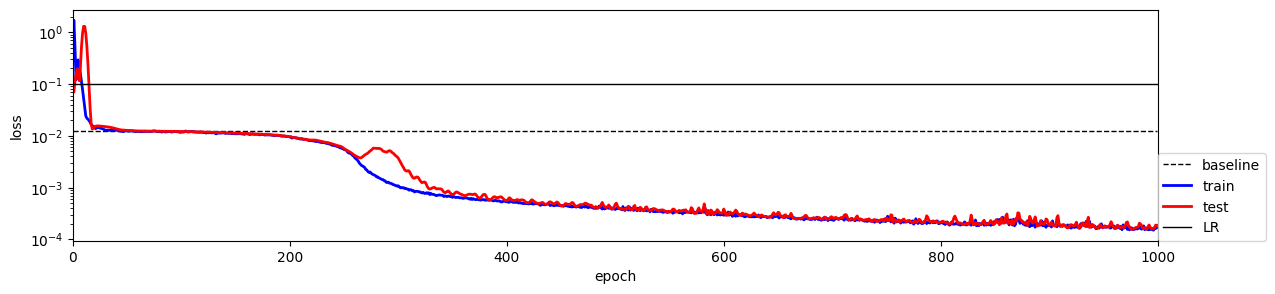

In [153]:
baseline = criterion(y_test, y_test*0 + y_test.mean()).item()


plt.figure(figsize=(14, 3))
plt.plot(losses1*0 + baseline, '--', c='black', label='baseline', lw=1)
plt.plot(losses1, c='blue', label='train', lw=2)
plt.plot(losses2, c='red', label='test', lw=2)
plt.plot(lrs, c='black', label='LR', lw=1)
# plt.ylim([0.00, 0.5])
plt.xlim([0, 1000])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc=(1,0))
plt.yscale('log')

Text(0, 0.5, 'y_test')

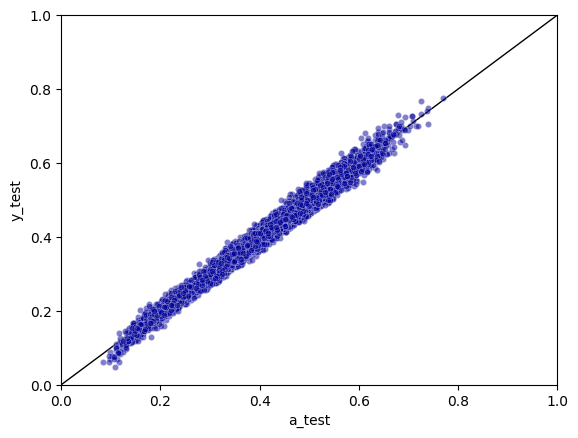

In [112]:
plt.plot([0, 1], [0, 1], 'k', lw=1, zorder=1)
plt.scatter(a_test.detach().cpu(), y_test.detach().cpu(), 20, c='#000099', edgecolor='w', lw=0.3, zorder=2, alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('a_test')
plt.ylabel('y_test')

In [66]:
X_test

tensor([[0.4540, 0.1965, 0.9210,  ..., 0.0659, 0.7476, 0.6253],
        [0.9392, 0.1338, 0.5191,  ..., 0.2761, 0.8396, 0.1563],
        [0.1072, 0.7261, 0.3241,  ..., 0.4138, 0.8621, 0.2793],
        ...,
        [0.8904, 0.3745, 0.0812,  ..., 0.0392, 0.1775, 0.0288],
        [0.3871, 0.8156, 0.6775,  ..., 0.5871, 0.0413, 0.6515],
        [0.7446, 0.7618, 0.6566,  ..., 0.0759, 0.9880, 0.5163]],
       device='cuda:0')

In [67]:
y_test

tensor([[0.5313],
        [0.2962],
        [0.3437],
        ...,
        [0.2164],
        [0.5167],
        [0.4532]], device='cuda:0')

In [68]:
a_test

tensor([[0.5390],
        [0.3029],
        [0.3350],
        ...,
        [0.2115],
        [0.5174],
        [0.4639]], device='cuda:0')

# Визуализация поверхности ошибок

* Но тут среди параметров и BN???

In [113]:
# https://olaralex.com/visualizing-the-loss-landscape/
# но там была ошибка

import copy

def init_directions(model):
    # случайная инициализация
    noises = []

    n_params = 0
    for name, param in model.named_parameters():
        delta = torch.normal(.0, 1., size=param.size(), device=device)
        nu = torch.normal(.0, 1., size=param.size(), device=device)

        param_norm = torch.norm(param)
        delta_norm = torch.norm(delta)
        nu_norm = torch.norm(nu)

        delta /= delta_norm
        delta *= param_norm

        nu /= nu_norm
        nu *= param_norm

        #if ("BN" in name) and ("weight" in name):
        #  delta *= 0
        #  nu *= 0
        #  print ("-")
        noises.append((delta, nu))

        n_params += np.prod(param.size())
        print (name, param.size())

    print(f'A total of {n_params:,} parameters.')

    return noises



def init_directions_frommodels(model, model1, model2):
    # из чекпоинтов
    noises = []

    n_params = 0
    for t, t1, t2 in zip(model.parameters(), model1.parameters(), model2.parameters()):
        delta = t.detach() - t1.detach()
        nu = t.detach() - t2.detach()

        t_norm = torch.norm(t)
        delta_norm = torch.norm(delta)
        nu_norm = torch.norm(nu)

        delta /= delta_norm
        delta *= t_norm

        nu /= nu_norm
        nu *= t_norm

        noises.append((delta, nu))

        n_params += np.prod(t.size())

    print(f'A total of {n_params:,} parameters.')

    return noises


def init_network(model, model_tmp, all_noises, alpha, beta):
    with torch.no_grad():
        for param, param_tmp, noises in zip(model.parameters(), model_tmp.parameters(), all_noises):
            delta, nu = noises
            # the scaled noises added to the current filter
            new_value = param + alpha * delta + beta * nu
            param_tmp.copy_(new_value)
    return model_tmp

In [118]:
# Creating the initial noise directions
# noises = init_directions(model)
noises = init_directions_frommodels(model, model1, model2)

# модель для экспериментов
model_tmp = copy.deepcopy(model)

# Our loss function (for categorical problems)
crit = nn.MSELoss()

RESOLUTION = 101
scale = 0.25 # 1.0

# The mesh-grid
A, B = np.meshgrid(scale*np.linspace(-1.0, 1.0, RESOLUTION),
                   scale*np.linspace(-1.0, 1.0, RESOLUTION), indexing='ij')

loss_surface = np.empty_like(A)

for i in range(RESOLUTION):
    for j in range(RESOLUTION):
        alpha = A[i, j]
        beta = B[i, j]
        # Initilazing the network to the current directions (alpha, beta)
        model_tmp = init_network(model, model_tmp, noises, alpha, beta) #.to('cuda')

        model_tmp.eval()

        with torch.no_grad():
          preds = model_tmp(X_test)
          loss = crit(preds, y_test)

        loss_surface[i, j] = loss.item()

        # print (alpha, beta, loss.item())
        # Freeing up GPU memory
del model_tmp
#torch.cuda.empty_cache()


A total of 3,271 parameters.


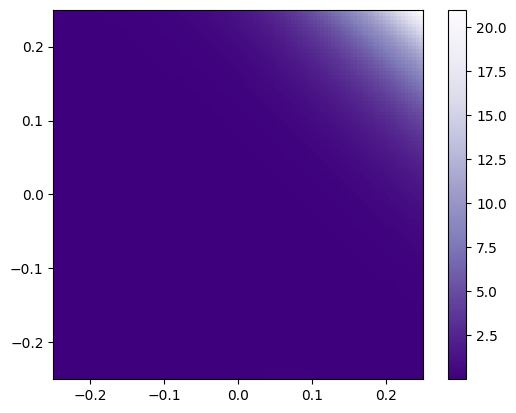

In [119]:
#model.named_parameters()
#model
# next(model.named_parameters())

plt.imshow(loss_surface, extent=[-scale, scale, -scale, scale], origin='lower',
           cmap='Purples_r', alpha=1.0)
plt.colorbar()

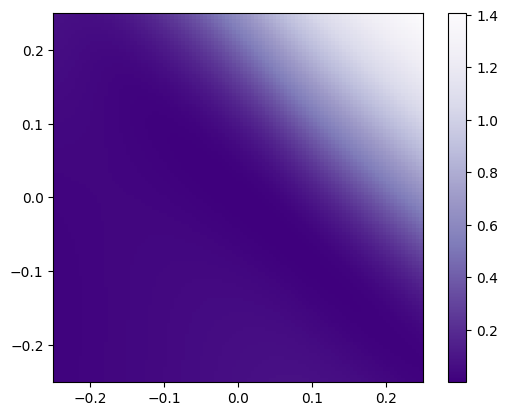

In [130]:
#plt.imshow(loss_surface, cmap='Blues')
plt.imshow(np.log1p(np.log1p(loss_surface)), extent=[-scale, scale, -scale, scale], origin='lower',
           cmap='Purples_r', alpha=1.0)
plt.colorbar()

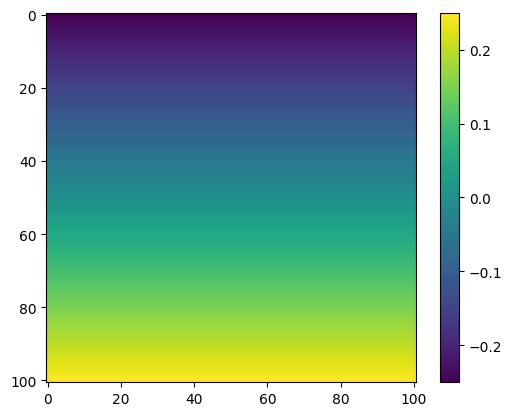

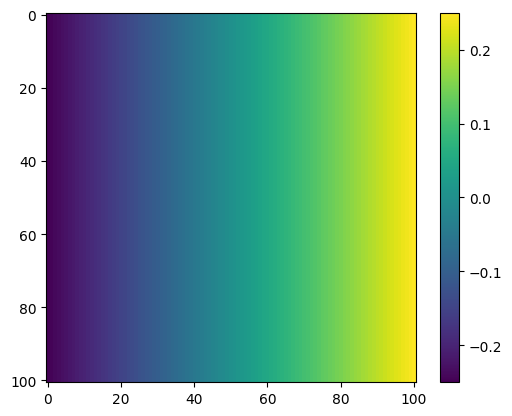

In [121]:
plt.imshow(A)
plt.colorbar()
plt.show()
plt.imshow(B)
plt.colorbar()
plt.show()

In [122]:
#net = init_network(model, noises, 0.0, 0.0).to('cuda')

crit(model(X_test), y_test) #,  crit(model_tmp(X_test), y_test)
#X_test #loss_surface

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)

In [123]:
Z = Zr.reshape([n_points, n_points])

plt.figure(figsize=(4,4))
plt.imshow(Z, extent=[-3.5, 3.5, -3.5, 3.5], origin='lower',
           cmap='Purples_r', alpha=1.0)
#plt.colorbar(orientation='horizontal', pad=0.02); ####### , ticks=[10, 20, 30]

#plt.tight_layout(h_pad = -0.15, w_pad = -0.2)

contours = plt.contour(X, Y, Z, [1, 2, 3], colors='white', lw=1, zorder=1)
# contours = plt.contour(X, Y, Z, 15, colors='white', lw=1, zorder=1)
# plt.scatter(x1, x2, 200, c='#000099', zorder=2, edgecolors='white', linewidth=1.0, label='интерес')
#plt.clabel(contours, inline=True, fontsize=8)

# plt.xticks([]);
# plt.yticks([]);
plt.plot(xs[:,0], xs[:,1], c='k', lw=1)
plt.scatter(xs[:,0], xs[:,1], 50, c="#000099", zorder=3, edgecolors='white', linewidth=0.5)

NameError: name 'Zr' is not defined

In [124]:
!pip install loss-landscapes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.3 MB/s eta 0:00:00


In [125]:
import loss_landscapes
import loss_landscapes.metrics

In [126]:
metric = loss_landscapes.metrics.Loss(criterion, X_train.to("cpu"), y_train.to("cpu"))
landscape = loss_landscapes.random_plane(model.to("cpu"), metric) #, normalize='filter')


#loss_data_fin = loss_landscapes.random_plane(model_final, metric, 10, STEPS, normalization='filter', deepcopy_model=True)


# data that the evaluator will use when evaluating loss
#x, y = iter(train_loader).__next__()
#metric = loss_landscapes.metrics.Loss(criterion, x, y)


In [127]:
next(model.parameters()).is_cuda # returns a boolean

False

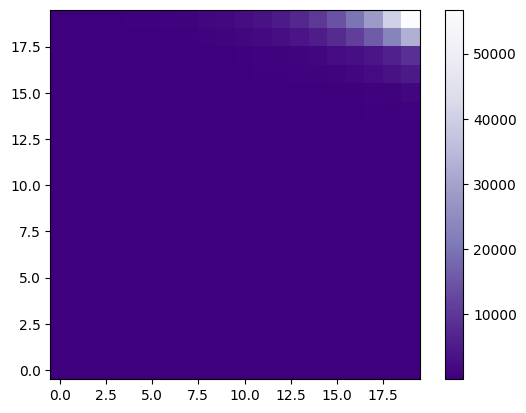

In [131]:
# metric, landscape

#plt.imshow(loss_surface, cmap='Blues')
plt.imshow(landscape, origin='lower',
           cmap='Purples_r', alpha=1.0) # extent=[-scale, scale, -scale, scale],
plt.colorbar()

# Двойной спуск

Там была ошибка и оказались пошаренные веса на разных слоях...

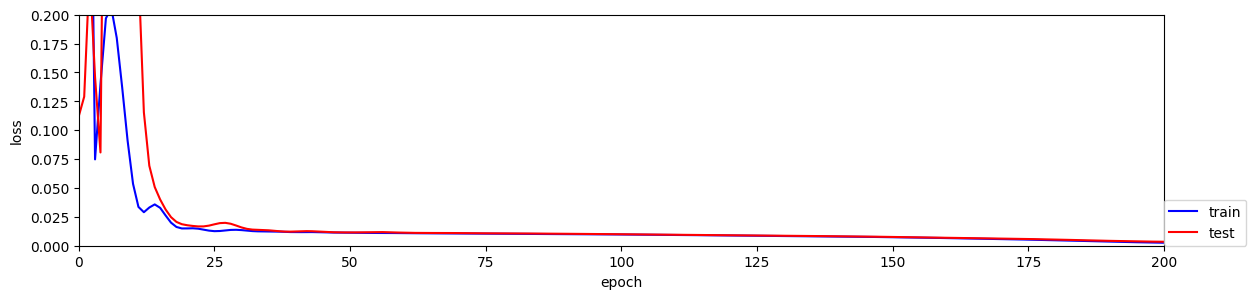

In [132]:
# n0 = 2 # число признаков в одном векторе
# n = 2 * n0  # общее число признаков
# m = 10000 # число объектов в выборке
# k = 2 # увеличение признакового пространства в сети
# nlayers = 5 # число слоёв в сети
# learning_rate = 1e-2

plt.figure(figsize=(14, 3))
plt.plot(losses1, c='blue', label='train')
plt.plot(losses2, c='red', label='test')
plt.ylim([0, 0.2])
plt.xlim([0, 200])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc=(1,0))

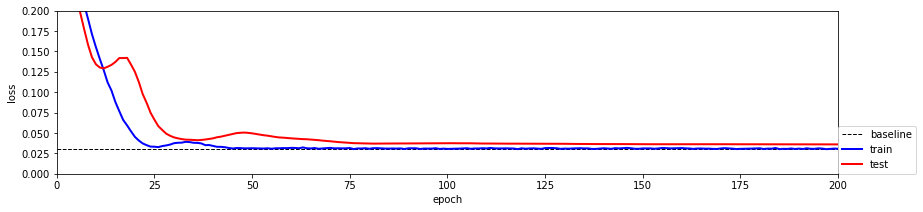

In [ ]:
# n0 = 2 # число признаков в одном векторе
# n = 2 * n0  # общее число признаков
# m = 10000 # число объектов в выборке
# k = 3 # увеличение признакового пространства в сети
# nlayers = 5 # число слоёв в сети
# learning_rate = 1e-2
# use_scheduler = True

baseline = criterion(ytest, ytest*0 + ytest.mean()).item()


plt.figure(figsize=(14, 3))
plt.plot(losses1*0 + baseline, '--', c='black', label='baseline', lw=1)
plt.plot(losses1, c='blue', label='train', lw=2)
plt.plot(losses2, c='red', label='test', lw=2)
plt.ylim([0, 0.2])
plt.xlim([0, 200])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc=(1,0))



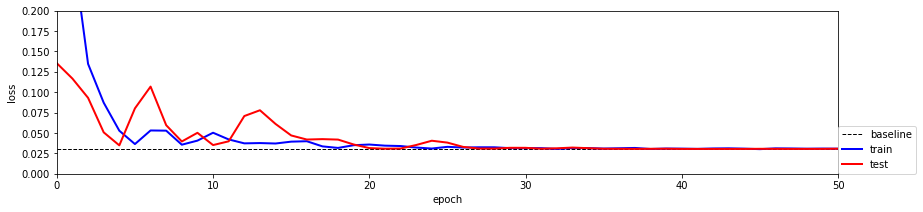

In [ ]:
#n0 = 2 # число признаков в одном векторе
#n = 2 * n0  # общее число признаков
#m = 10000 # число объектов в выборке
#k = 3 # увеличение признакового пространства в сети
#nlayers = 5 # число слоёв в сети
#learning_rate = 1e-1
#use_scheduler = True

baseline = criterion(ytest, ytest*0 + ytest.mean()).item()


plt.figure(figsize=(14, 3))
plt.plot(losses1*0 + baseline, '--', c='black', label='baseline', lw=1)
plt.plot(losses1, c='blue', label='train', lw=2)
plt.plot(losses2, c='red', label='test', lw=2)
plt.ylim([0, 0.2])
plt.xlim([0, 50])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc=(1,0))

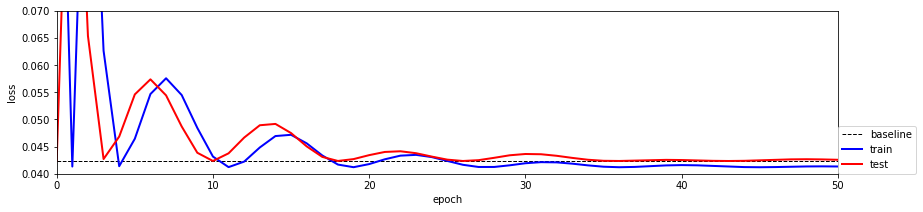

In [ ]:
# на совсем простой сети и задачи...
baseline = criterion(y_test, y_test*0 + y_test.mean()).item()


plt.figure(figsize=(14, 3))
plt.plot(losses1*0 + baseline, '--', c='black', label='baseline', lw=1)
plt.plot(losses1, c='blue', label='train', lw=2)
plt.plot(losses2, c='red', label='test', lw=2)
plt.ylim([0.04, 0.07])
plt.xlim([0, 50])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc=(1,0))

In [ ]:
for name, param in model.named_parameters():
  print (name)
  print (param)

L0.weight
Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1656,  0.6496],
        [-0.1549,  0.1427],
        [-0.3442,  0.4153],
        [ 0.6234, -0.5187],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0957],
        [ 0.3411, -0.0997],
        [ 0.5452,  0.1046],
        [-0.3301,  0.1802],
        [-0.3258, -0.0829],
        [-0.2872,  0.4690],
        [-0.5582, -0.3260],
        [-0.1996, -0.4251],
        [ 0.0668, -0.6984],
        [ 0.6386, -0.6006],
        [ 0.5459,  0.1177],
        [-0.2295,  0.4371],
        [ 0.1102,  0.5713],
        [ 0.0773, -0.2230]], device='cuda:0', requires_grad=True)
L0.bias
Parameter containing:
tensor([ 0.1900, -0.1917,  0.2977,  0.6314,  0.4089, -0.3091,  0.4081,  0.1268,
         0.3593, -0.4310, -0.7000, -0.2732, -0.5424,  0.5803,  0.2038,  0.2929,
         0.2237, -0.0121,  0.5534, -0.5024], device='cuda:0',
       requires_grad=True)
L1.weight
Parameter containing:
tensor([[ 0.0141, -0.1526,  0.0689, -0.0770,  0.0685, -0.04

# Вот Такой был баг

если размеры ответа и целевого вектора разные

In [32]:
cr = nn.MSELoss()
t1 = torch.tensor([1., 2.])
t2 = torch.tensor([[1., 2.]]).T
print (t1.shape, t2.shape, cr(t1, t2))

torch.Size([2]) torch.Size([2, 1]) tensor(0.5000)


In [34]:
cr = nn.MSELoss()
t1 = torch.tensor([1., 2.])
t2 = torch.tensor([1., 5.])
print (t1.shape, t2.shape, cr(t1, t2))

torch.Size([2]) torch.Size([2]) tensor(4.5000)


In [39]:
cr = nn.MSELoss()
t1 = torch.tensor([[1., 2.]]).T
t2 = torch.tensor([[1., 5.]]).T
print (t1.shape, t2.shape, cr(t1, t2))

torch.Size([2, 1]) torch.Size([2, 1]) tensor(4.5000)


In [ ]:
m1 = copy.deepcopy(model)